# Diffusion Boundary

The simulation script described in this chapter is available at [STEPS_Example repository](https://github.com/CNS-OIST/STEPS_Example/blob/master/user_manual/source/diffusion_boundary.ipynb).

In some systems it may be a convenient simulation feature to be able to localize certain chemical species in one particular region of a volume without diffusion to neighboring regions even if they are not separated by a physical boundary. For example, in some biological systems certain proteins may exist only in local regions and though the structural features are simplified in a model the proteins are assumed to diffuse in a local region to meet and react with each other. So it is sometimes important to restrict the diffusional space of some proteins and not the others from a biologically feasible perspective. Similarly, it may be convenient to separate a large simulation volume into a number of compartments that are not physically separated by a membrane and so are connected to other compartments by chemical diffusion. Such an approach allows for different biochemical behavior in different regions of the volume to be specified and may simplify simulation initialization and data recording considerably. In this brief chapter we'll introduce an object termed the “Diffusion Boundary“ ([steps.geom.DiffBoundary](API_geom.rst#steps.geom.DiffBoundary)) which allows for this important simulation convenience: optional chemical diffusion between connected mesh compartments.

The Diffusion Boundary of course can only be added to a mesh-based (i.e. not a well-mixed) simulation and is described by a collection of triangles. These triangles must form some or all of the connection between two (and only two) compartments, and none of the triangles may already be described as part of a “Patch“ ([steps.geom.TmPatch](API_geom.rst#steps.geom.TmPatch)). It is not possible for two compartments to be connected in the same area by a Patch and a Diffusion Boundary since a Patch is intended to model a membrane and a Diffusion Boundary is just some internal area within a volume that may block diffusion, and it would be unrealistic to allow surface reactions and free diffusion to occur in the same area. Once a Diffusion Boundary is in place the modeler may specify which chemical species (if any) may freely diffuse through the boundary. Diffusion boundaries are currently supported in solvers [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) and [steps.mpi.solver.TetOpSplit](API_mpi.rst#steps.mpi.solver.TetOpSplit), but for this chapter we will only demonstrate usage in Tetexact. For approximate MPI simulations with TetOpSplit please see later chapters.

For the example we'll set up a simple system to introduce the [steps.geom.DiffBoundary](API_geom.rst#steps.geom.DiffBoundary) object and expand on our mesh manipulation in previous chapters through STEPS methods provided in the Python interface. The simple examples here may of course be expanded and built on for more complex mesh manipulations in detailed, realistic simulations, though greater complexity is beyond the scope of this chapter.


## Modeling solution

### Organisation of code

To run our simulation we'll, as usual, create a Python script, following a similar structure to previous chapters. Again, for clarity, we'll show Python code as if typed at the prompt and go through the code step by step looking at some statements in detail as we go.

To get started we import STEPS and outside packages as usual:


In [1]:
import steps.model as smodel
import steps.geom as sgeom
import steps.rng as srng
import steps.solver as solvmod
import steps.utilities.meshio as meshio
import numpy
import pylab

### Model specification

We'll go straight into our function that will set up the biochemical model. Here we will create two chemical species objects, 'X' and 'Y', and describe their diffusion rules. Notice that this time we use separate volume systems for the two compartments we will create, as is our option. We intend volume system 'vsysA' to be added to a compartment 'A' and 'vsysB' to be added to compartment 'B', the reason for which will become clear as we progress:


In [2]:
def gen_model():

    # Create the model container object
    mdl = smodel.Model()

    # Create the chemical species
    X = smodel.Spec('X', mdl)
    Y = smodel.Spec('Y', mdl)

    # Create separate volume systems for compartments A and B
    vsysA = smodel.Volsys('vsysA', mdl)
    vsysB = smodel.Volsys('vsysB', mdl)

    # Describe diffusion of molecules in compartments A and B
    diff_X_A = smodel.Diff('diff_X_A', vsysA, X, dcst = 0.1e-9)
    diff_X_B = smodel.Diff('diff_X_B', vsysB, X, dcst = 0.1e-9)
    diff_Y_A = smodel.Diff('diff_Y_A', vsysA, Y, dcst = 0.1e-9)
    diff_Y_B = smodel.Diff('diff_Y_B', vsysB, Y, dcst = 0.1e-9)

    # Return the container object
    return mdl

Note that if our model were set up with the following code instead, diffusion would NOT be defined for species 'X' in compartment 'B' (if we add only volume system 'B' to compartment 'B' as we intend):

    # Describe diffusion of molecules in compartments A and B
    # NOTE: diffusion is not defined for species X in compartment B
    diff_X = smodel.Diff('diff_X', vsysA, X, dcst = 0.1e-9)
    diff_Y_A = smodel.Diff('diff_Y_A', vsysA, Y, dcst = 0.1e-9)
    diff_Y_B = smodel.Diff('diff_Y_B', vsysB, Y, dcst = 0.1e-9)


This is an important point because if a species does not react or diffuse within a compartment (as is the case for 'X' in compartment 'B' here) it is undefined in the compartment by the solver- it does nothing in the compartment so memory and simulation time is not wasted by including the species in that compartment during simulation. For this reason if we were to later try to allow diffusion of 'X' across the diffusion boundary during our simulation in this example we would receive an error message because it may not diffuse into compartment 'B' since it is undefined there.


### Geometry specification

Next we define our geometry function. Because some of the operations are new we'll look at the code in more detail.


First we import our mesh, a cylinder of axial length 10 microns (on the z-axis)  which we have previously imported and saved in STEPS format (with method [steps.utilities.meshio.saveMesh](API_utilities.rst#steps.utilities.meshio.saveMesh)) in folder 'meshes' in the current directory.

![The mesh used for the diffusion boundary simulation](images/diffbound_fig1.png)

Here, the object that is returned to us and stored by `mesh` will be a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object, which is the zeroth element of the tuple returned by the function:

In [3]:
mesh = meshio.loadMesh('meshes/cyl_len10_diam1')[0]

Now we'll create our two compartments. We'll split our cylinder down the middle of the z-axis creating two compartments of (approximately) equal volume. Since our cylinder is oriented on the z-axis we simply need to separate tetrahedrons by those that are below the centre point on the z-axis and those that are above.

Firstly we count the number of tetrahedrons using method [steps.geom.Tetmesh.countTets](API_geom.rst#steps.geom.Tetmesh.countTets):

In [4]:
ntets = mesh.countTets()

And create empty lists to group the tetrahedrons as those that belong to compartment 'A' and those to 'B':

In [5]:
tets_compA = []
tets_compB = []

And similarly create empty sets to group all the triangles in compartments 'A' and 'B'. All tetrahedrons are comprised of 4 triangles, and we store all triangles belonging to all tetrahedrons in the compartment (in a set so as not to store more than once). The reason for doing so will become apparent soon:


In [6]:
tris_compA = set()
tris_compB = set()

Next we find the bounds of the mesh, and the mid point (on the z-axis)- the point at which we want our Diffusion Boundary to appear:

In [7]:
z_max = mesh.getBoundMax()[2]
z_min = mesh.getBoundMin()[2]
z_mid = z_min+(z_max-z_min)/2.0

Now we’ll run a for loop over all tetrahedrons to sort tetrahedrons and triangles into the compartments. The criterior is that tetrahedrons with their barycenter less than the mid point on the z-axis will belong to compartment `A` and those with their barycenter greater than the mid point will belong to compartment `B`:

In [8]:
for t in range(ntets):
    # Fetch the z coordinate of the barycenter
    barycz = mesh.getTetBarycenter(t)[2]
    # Fetch the triangle indices of the tetrahedron, a tuple of length 4:
    tris = mesh.getTetTriNeighb(t)
    if barycz < z_mid:
        tets_compA.append(t)
        tris_compA.add(tris[0])
        tris_compA.add(tris[1])
        tris_compA.add(tris[2])
        tris_compA.add(tris[3])
    else:
        tets_compB.append(t)
        tris_compB.add(tris[0])
        tris_compB.add(tris[1])
        tris_compB.add(tris[2])
        tris_compB.add(tris[3])

With our tetrahedrons sorted in this way we can create our mesh compartments. As we have seen in the previous chapter, a [steps.geom.TmComp](API_geom.rst#steps.geom.TmComp) requires to the constructor, in order: a unique string identifier, a reference to the parent [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) container object, and all the indices of the tetrahedrons that comprise the compartment in a Python sequence such as a list or tuple

In [9]:
compA = sgeom.TmComp('compA', mesh, tets_compA)
compB = sgeom.TmComp('compB', mesh, tets_compB)

And add volume system 'vsysA' to compartment 'A' and volume system 'vsysB' to compartment 'B':

In [10]:
compA.addVolsys('vsysA')
compB.addVolsys('vsysB')

Now comes our diffusion boundary as part of our geometry description and therefore the Diffusion Boundary class is to be found in module [steps.geom](API_geom.rst#steps.geom) which we have imported with name `sgeom`. Recall that, to create a diffusion boundary, we must have a sequence of all the triangle indices that comprise the diffusion boundary and all of the triangles must connect the same two compartments. The reason that the user has to explicitly declare which triangles to use is that the diffusion boundary between compartments may not necessarily form the whole surface between the two compartments and may comprise a smaller area. However here we will use the entire surface between the two compartments.

The way that we find the triangle indices is very straightforward- they are simply the common triangles to both compartments. We have the triangle indices of both compartments stored in Python sets, the common triangles are therefore the intersection:

In [11]:
tris_DB = tris_compA.intersection(tris_compB)

If this point is not very clear, consider the simple example where two tetrahedrons are connected at a surface (triangle). Lets say tetrahedron A is comprised of triangles (0,1,2,3) and tetrahedron B is comprised of triangles (0,4,5,6). That would mean that their common triangle (0) forms their connection. The common triangle could be found by finding the intersection of two sets of the triangles, that is the intersection of (0,1,2,3) and (0,4,5,6) is (0). That is what the above code does on a larger scale where the sets contain all triangles in the entire compartment and the intersection therefore gives the entire surface connection between the two compartments.

Now we have to convert the set to a list (or other sequence such as a tuple or NumPy array) as this is what the diffusion boundary constructor requires:

In [12]:
tris_DB = list(tris_DB)

Finally we can create the diffusion boundary between compartment 'A' and compartment 'B'. The object constructor looks similar to that for a mesh compartment or patch, but with some important differences. That is the constructor expects, in order: a unique string identifier, a reference to the parent [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) container, and a sequence of all triangles that comprise the boundary. Note that no references to the compartments that the boundary connects are required- these are found internally and checked to be common amongst all triangles in the diffusion boundary:

In [13]:
diffb = sgeom.DiffBoundary('diffb', mesh, tris_DB)

And that is basically all we need to do create our diffusion boundary. As usual we should note the string identifier because that is what we will need to control the diffusion boundary during simulation. The technique for finding the common triangles between two compartments is a very useful technique that may be applied or adapted when creating diffusion boundaries in most STEPS simulations.

We return the parent [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object, along with the lists of tetrahedrons by compartment at the end of our function body.

Our entire function code is:

In [14]:
def gen_geom():
    mesh = meshio.loadMesh('meshes/cyl_len10_diam1')[0]
    ntets = mesh.countTets()
    tets_compA = []
    tets_compB = []
    tris_compA = set()
    tris_compB = set()
    z_max = mesh.getBoundMax()[2]
    z_min = mesh.getBoundMin()[2]
    z_mid = z_min+(z_max-z_min)/2.0
    for t in range(ntets):
        # Fetch the z coordinate of the barycenter
        barycz = mesh.getTetBarycenter(t)[2]
        # Fetch the triangle indices of the tetrahedron, which is a tuple of length 4
        tris = mesh.getTetTriNeighb(t)
        if (barycz < z_mid):
            tets_compA.append(t)
            tris_compA.add(tris[0])
            tris_compA.add(tris[1])
            tris_compA.add(tris[2])
            tris_compA.add(tris[3])
        else:
            tets_compB.append(t)
            tris_compB.add(tris[0])
            tris_compB.add(tris[1])
            tris_compB.add(tris[2])
            tris_compB.add(tris[3])
    compA = sgeom.TmComp('compA', mesh, tets_compA)
    compB = sgeom.TmComp('compB', mesh, tets_compB)
    compA.addVolsys('vsysA')
    compB.addVolsys('vsysB')
    tris_DB = tris_compA.intersection(tris_compB)
    tris_DB = list(tris_DB)
    diffb = sgeom.DiffBoundary('diffb', mesh, tris_DB)
    return mesh, tets_compA, tets_compB

### Simulation with ``Tetexact``

So now we come to our example simulation run. As in the previous chapter we will create the 3 important objects required to the solver constructor, which are: a [steps.model.Model](API_model.rst#steps.model.Model) object (returned by our ``gen_model`` function), a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object (for a mesh-based simulation; returned by our ``gen_geom`` function) and a [steps.rng.RNG](API_rng.rst#steps.rng.RNG) object that we will create.
We generate our [steps.model.Model](API_model.rst#steps.model.Model) container object with a call to function ``gen_geom`` and store in variable `mdl`:

In [15]:
mdl = gen_model()

Note that, as well as the [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) container object, the ``gen_geom`` function also returns the indices of the terahedrons for both compartments, which we will store in variables ``tets_compA`` and ``tets_compB``:


In [16]:
mesh, tets_compA, tets_compB = gen_geom()

As in previous chapters, create our random number generator and initialise with some seed value:


In [17]:
rng = srng.create('mt19937', 256)
rng.initialize(654)

And create our solver object, using [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) for a mesh-based diffusion simulation with the usual object references to the solver constructor, which to recall are (in order): a [steps.model.Model](API_model.rst#steps.model.Model) object, a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object, and a [steps.rng.RNG](API_rng.rst#steps.rng.RNG) object:


In [18]:
sim = solvmod.Tetexact(mdl, mesh, rng)
sim.reset()

Now to create the data structures for running our simulation and storing data. There are many ways to achieve our aims here, but we will follow a pattern set by previous chapters which is first to create a NumPy array for “time-points“ to run the simulation, and find how many “time-points“ we have:


In [19]:
tpnts = numpy.arange(0.0, 0.101, 0.001)
ntpnts = tpnts.shape[0]

And now create our structures for storing data, again NumPy arrays, but this time of a size to record data from every tetrahedron in the mesh. We record how many tetrahedrons there are by using method `countTets` on our mesh object ([steps.geom.Tetmesh.countTets](API_geom.rst#steps.geom.Tetmesh.countTets)). We also separate our results arrays, one to record from compartment 'A' and one for compartment 'B':


In [20]:
ntets = mesh.countTets()
resX = numpy.zeros((ntpnts, ntets))
resY = numpy.zeros((ntpnts, ntets))

Next, let's assume we wish to inject our molecules at the two ends of the cylinders, that is the points at which our z-axis is at a minimum and and a maximum. From creating our mesh (or finding out through methods `getBoundMax` and `getBoundMin` on our [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object) we know that our boundaries are at z = -5 microns and +5 microns. To find the tetrahedrons at the centre points of the two boundaries (i.e. at x=0 and y=0) we use [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) method `findTetByPoint`, which will return the index of the tetrahedron that encompasses any point given in 3D cartesian coordinates as a Python sequence. We give points slightly inside the boundary so as to be sure that our point is inside the mesh (the method will return -1 if not):


In [21]:
tetX = mesh.findTetByPoint([0, 0, -4.99e-6])
tetY = mesh.findTetByPoint([0, 0, 4.99e-6])

Let's set our initial conditions by injecting 1000 molecules of species 'X' into the lower Z boundary tetrahedron (which will be contained in compartment 'A') and 500 molecules of species 'Y' into the upper z boundary tetrahedron (which will be contained in compartment 'B') [#f1]_:


In [22]:
sim.setTetCount(tetX , 'X', 1000)
sim.setTetCount(tetY, 'Y', 500)

Now for the main focus of this chapter, which is to allow diffusion between the compartments joined by a Diffusion Boundary. During our geometry construction we already created our [steps.geom.DiffBoundary](API_geom.rst#steps.geom.DiffBoundary) object (named rather unimaginatively 'diffb') which will be included in the simulation, with the default behaviour to block diffusion between compartment 'A' and 'B' completely for all molecules. We now wish to allow diffusion of species 'Y' through the boundary which we achieve with one simple solver method call. Importantly, we would be unable to activate diffusion through the boundary for species 'X'; this is because 'X' is undefined in compartment 'B' since it does not appear in any reaction or diffusion rules there.

To activate diffusion through the boundary we call the rather wordy [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) solver method `setDiffBoundaryDiffusionActive` ([steps.solver.Tetexact.setDiffBoundaryDiffusionActive](API_solver.rst#steps.solver.Tetexact.setDiffBoundaryDiffusionActive)), with 3 arguments to the function; the string identifier of the diffusion boundary ('diffb'), the string identifier of the species ('Y') and a bool as to whether diffusion through the boundary is active or not (`True`):


In [23]:
sim.setDiffBoundaryDiffusionActive('diffb', 'Y', True)

And that is all we need to do to activate diffusion of species 'Y' through the diffusion boundary 'diffb' and therefore allow diffusion of 'Y' between compartments 'A' and 'B'. To inactivate diffusion (which is incidentally the default behaviour for all species) we would call the same function with boolean `False`.

So now a simple `for` loop to run our simulation. We have already constructed our NumPy arrays for this purpose: `tpnts` stores the times that we run our simulation and collect our data for (we chose 1ms increments up to 100ms) and `ntpnts` stores how many of these 'time-points' there are, which is 101 (including time=0). At every time-point we will collect our data, here recording the number of molecules of 'X' and 'Y' in every tetrahedron in the mesh.

In [24]:
for i in range(ntpnts):
    sim.run(tpnts[i])
    for k in range(ntets):
        resX[i, k] = sim.getTetCount(k, 'X')
        resY[i, k] = sim.getTetCount(k, 'Y')

### Plotting simulation output

Having run our simulation it now comes to visualizing and analyzing the output of the simulation. One way to do this is to plot the data, once again using the plotting capability from Matplotlib.

Let's assume we want a spatial plot- distance on the z-axis vs concentration- but don't want to plot every tetrahedron individually. In other words we want to split the cylinder into bins with equal width on the z-axis. Then we record counts from a tetrahedron and add it to the bin that the tetrahedron belongs to. We could, of course, have set up structures to record data from bins before and during our simulation, but instead we will use the data that we have recorded in all individual tetrahedrons (in the code above) to read and split into bins for plotting. And that is exactly what is achieved in the following function, which won't contain a detailed step-by-step explanation as it is not strictly STEPS code, but is included for the user to see how such tasks may be achieved. This function does use some structures defined outside of the function, such as `tpnts`, so would have to appear after the previous code in a Python script to work as it is:


In [25]:
from __future__ import print_function # for backward compatibility with Py2

def plot_binned(t_idx, bin_n = 100, solver='unknown'):
    if (t_idx > tpnts.size):
        print("Time index is out of range.")
        return

    # Create structure to record z-position of tetrahedron
    z_tets = numpy.zeros(ntets)

    zbound_min = mesh.getBoundMin()[2]

    # Now find the distance of the centre of the tets to the Z lower face
    for i in range(ntets):
        baryc = mesh.getTetBarycenter(i)
        z = baryc[2] - zbound_min
        # Convert to microns and save
        z_tets[i] = z*1.0e6

    # Find the maximum and minimum z of all tetrahedrons
    z_max = z_tets.max()
    z_min = z_tets.min()

    # Set up the bin structures, recording the individual bin volumes
    z_seg = (z_max-z_min)/bin_n
    bin_mins = numpy.zeros(bin_n+1)
    z_tets_binned = numpy.zeros(bin_n)
    bin_vols = numpy.zeros(bin_n)

    # Now sort the counts into bins for species 'X'
    z = z_min
    for b in range(bin_n + 1):
        bin_mins[b] = z
        if (b!=bin_n): z_tets_binned[b] = z +z_seg/2.0
        z+=z_seg
    bin_counts = [None]*bin_n
    for i in range(bin_n): bin_counts[i] = []
    for i in range((resX[t_idx].size)):
        i_z = z_tets[i]
        for b in range(bin_n):
            if(i_z>=bin_mins[b] and i_z<bin_mins[b+1]):
                bin_counts[b].append(resX[t_idx][i])
                bin_vols[b]+=sim.getTetVol(i)
                break

    # Convert to concentration in arbitrary units
    bin_concs = numpy.zeros(bin_n)
    for c in range(bin_n):
        for d in range(bin_counts[c].__len__()):
            bin_concs[c] += bin_counts[c][d]
        bin_concs[c]/=(bin_vols[c]*1.0e18)

    t = tpnts[t_idx]

    # Plot the data
    pylab.scatter(z_tets_binned, bin_concs, label = 'X', color = 'blue')

    # Repeat the process for species 'Y'- separate from 'X' for clarity:
    z = z_min
    for b in range(bin_n + 1):
        bin_mins[b] = z
        if (b!=bin_n): z_tets_binned[b] = z +z_seg/2.0
        z+=z_seg
    bin_counts = [None]*bin_n
    for i in range(bin_n): bin_counts[i] = []
    for i in range((resY[t_idx].size)):
        i_z = z_tets[i]
        for b in range(bin_n):
            if(i_z>=bin_mins[b] and i_z<bin_mins[b+1]):
                bin_counts[b].append(resY[t_idx][i])
                break
    bin_concs = numpy.zeros(bin_n)
    for c in range(bin_n):
        for d in range(bin_counts[c].__len__()):
            bin_concs[c] += bin_counts[c][d]
        bin_concs[c]/=(bin_vols[c]*1.0e18)

    pylab.scatter(z_tets_binned, bin_concs, label = 'Y', color = 'red')

    pylab.xlabel('Z axis (microns)', fontsize=16)
    pylab.ylabel('Bin concentration (N/m^3)', fontsize=16)
    pylab.ylim(0)
    pylab.xlim(0, 10)
    pylab.legend(numpoints=1)
    pylab.title('Simulation with '+ solver)
    pylab.show()

This function will plot the bin concentration of both species 'X' and 'Y' along the z-axis for any of our “time-points“, with the default number of bins being 100. We run our simulation up to 100ms, which was the 100th time-point so lets plot that with call 


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


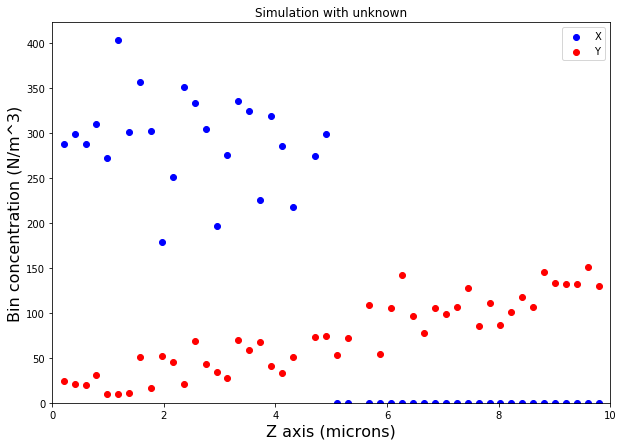

In [26]:
pylab.figure(figsize=(10,7))
plot_binned(100, 50)

The binned concentrations of species 'X' and 'Y' are plotted at time 100ms.The diffusion boundary allows diffusion of species 'Y' between compartments,but blocks the diffusion of species 'X', which is therefore contained in compartment 'A' (left half of figure).

The figure shows species 'Y' diffuse from compartment B to compartment A freely, while 'X' is  clearly contained in compartment 'A' by the central diffusion boundary.